In this notebook, I'll be exploring the transportation modes and time, and creating csv files.

In [52]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns

In [2]:
# import data:
NS_transportation = pd.read_csv('original_mode_transportation_data.csv')

In [3]:
time = pd.read_csv('time.csv')

In [4]:
NS_transportation = pd.merge(time, NS_transportation, on = 'participant_ID')

In [5]:
NS_transportation.describe(include = 'all')

,participant_ID,time_to_get_to_most_visited_OFB,mode_transportation_walk,mode_transportation_cycle,mode_transportation_public,mode_transportation_private,mode_transportation_prefer_not_to_answer,mode_transportation_others
count,4054,4054,1358,524,1989,910,151,95
unique,4054,5,1,1,1,1,1,75
top,ns 757,less than 30 minutes,walk,cycle,public transportation,private transportation,prefer not to answer,car
freq,1,1643,1358,524,1989,910,151,6


We can see that there are multiple values in the "other" column, let's check them out:

In [6]:
NS_transportation.mode_transportation_others.unique()

array([nan, 'public bus', 'drive',
       'they deliver to our apartment building', 'bus',
       'whenever my mother is available to drive me', 'our car',
       'iâ€™d have to get one of my workers to drive me cas or ottawa',
       'initially we used to walk there, until they moved - now it is impossible to reach unless i am fortunate and get a ride from someone kind enough to offer',
       'a poorly functioning car', 'a friend drives me', 'find a drive',
       'i do not visit', 'friend help', 'friend', 'get help from someone',
       'get help from sister', 'drive, bus', 'car',
       'sometimes friends drive me', 'get dropped',
       'sometime public and sometime private transportation',
       'wheel chair', 'my son assists me in carrying the food.',
       'walk or take the bus',
       'i go for breakfast and lunch and socializing with people and live close, so i walk to the institution',
       'wheelchair', '7th', 'and sometimes they deliver to me.',
       'they come to t

In [7]:
NS_transportation.columns

Index(['participant_ID', 'time_to_get_to_most_visited_OFB',
       'mode_transportation_walk', 'mode_transportation_cycle',
       'mode_transportation_public', 'mode_transportation_private',
       'mode_transportation_prefer_not_to_answer',
       'mode_transportation_others'],
      dtype='object')

In [8]:
# Define keywords for each option
keywords = {
    'walk': ['walk', 'walking', 'on foot','skateboard'],
    'cycle': ['bike', 'biking', 'cycle'],
    'public transportation': ['bus', 'public', 'para', 'transpo', 'subway', 'train'],
    'private transportation': ['car', 'drive', 'my', 'own car', 'ride','bf', 'family','friend', 'help','carpool', 'dropped', 'uber', 'taxi'],
    'prefer not to answer': ['none', 'not applicable', 'nil', 'other', '7th'],
    'food delivery option' : ['deliver', 'not visit', 'not go', "don't", 'building', 'cite'],
    'mobility devices': [ 'wheelchair', 'chair', 'scooter', 'mobility', 'small-wheeled']
    }

In [9]:
# I'll create columns for the new transportation options:
NS_transportation[['mode_transportation_food_delivery_option','mode_transportation_mobility_devices']] = None

In [10]:
# Function to classify answers based on keywords
def classify_transportation(answer, keywords):
        
    if isinstance(answer, str):
        answer_lower = answer.lower()
        matched_options = []
        
        for option, keywords in keywords.items():
            if any(keyword in answer_lower for keyword in keywords):
                if option not in matched_options:
                    matched_options.append(option)

        if len(matched_options) > 1:
            if 'prefer not to answer' in matched_options:
                matched_options.remove('prefer not to answer')
            elif  "i don't know" in matched_options:
                matched_options.remove("i don't know")
                
        return ';'.join(matched_options) if matched_options else "other"
    
    return answer # Default to ''answer' if no match found


In [11]:
# Apply the function to map each answer to provided options
NS_transportation['mapped_transportation'] = NS_transportation['mode_transportation_others'].apply(lambda x: classify_transportation(x, keywords))

In [12]:
NS_transportation.describe(include = 'all')

,participant_ID,time_to_get_to_most_visited_OFB,mode_transportation_walk,mode_transportation_cycle,mode_transportation_public,mode_transportation_private,mode_transportation_prefer_not_to_answer,mode_transportation_others,mode_transportation_food_delivery_option,mode_transportation_mobility_devices,mapped_transportation
count,4054,4054,1358,524,1989,910,151,95,0,0,95
unique,4054,5,1,1,1,1,1,75,0,0,12
top,ns 757,less than 30 minutes,walk,cycle,public transportation,private transportation,prefer not to answer,car,NaN,NaN,private transportation
freq,1,1643,1358,524,1989,910,151,6,NaN,NaN,48


In [13]:
NS_transportation.mapped_transportation.value_counts()

mapped_transportation
private transportation                              48
food delivery option                                17
public transportation                                8
mobility devices                                     7
prefer not to answer                                 6
walk;public transportation                           2
walk                                                 2
walk;private transportation                          1
public transportation;private transportation         1
walk;cycle                                           1
walk;mobility devices                                1
walk;private transportation;food delivery option     1
Name: count, dtype: int64

In [14]:
#Now we can drop the mode_trasportation_others column:
NS_transportation.drop('mode_transportation_others', axis = 1, inplace = True)

In [15]:
# create a function to consolidate the data:
def consolidate_row(row):
    """ 
    Consolidate answers from a DataFrame row, excluding the first and last columns.

    This function processes a row from a DataFrame to:
    1. Create a list of consolidated answers from specified columns, excluding the "participant_ID" (first column) and the last column.
       - Only non-null and non-empty values are included in the list.
    2. Count the number of answers provided.
    3. If the consolidated list contains "prefer not to answer", the list is updated to contain only this value.
    4. Return the consolidated answers as a single string and the count of answers.

    Parameters:
    row (pd.Series): A row from a DataFrame containing answers to be consolidated.

    Returns:
    tuple: A tuple containing:
           - A string of consolidated answers, joined by '; '.
           - An integer count of the number of answers provided.
    """
        
    consolidated = []
    
    # Loop through the specified columns excluding the "participant_ID" and last columns:
    for value in row.iloc[2:]:
        if pd.notna(value)  and value != '':
            values = value.split(';') 
            for value in values:
                if value not in consolidated:
                    consolidated.append(value)
        
    
    consolidated_answer = ';'.join(consolidated)
    
    # finding out how many answers were provided:
    number_of_answers = len(consolidated_answer.split(';'))
    
    # ensuring we don't get any '' in the final result:
    if consolidated_answer == '':
        consolidated_answer = 'prefer not to answer'
        number_of_answers = 0
        
    # updating the records for "i don't know":
    if "i don't know" in consolidated:
        consolidated_answer = "i don't know"
        
    # updating the records for "prefer not to answer":
    if 'prefer not to answer' in consolidated:
        consolidated_answer = 'prefer not to answer'
    
    # updating questionable answers:
    if number_of_answers > 5:
        consolidated_answer = 'prefer not to answer'
        
    
    return consolidated_answer , number_of_answers

In [16]:
# Apply the consolidate_row function to each row and create new columns:
NS_transportation[['transportation_consolidated', 'transportation_number_of_answers']] = NS_transportation.apply(
        lambda row: pd.Series(consolidate_row(row)), axis=1 )

In [17]:
# Since all mapped modes are in the consolidated column, i'll drop the mapped_transportation column:
NS_transportation.drop('mapped_transportation', axis = 1, inplace = True)

In [18]:
# checking null values:
NS_transportation.isna().sum()

participant_ID                                 0
time_to_get_to_most_visited_OFB                0
mode_transportation_walk                    2696
mode_transportation_cycle                   3530
mode_transportation_public                  2065
mode_transportation_private                 3144
mode_transportation_prefer_not_to_answer    3903
mode_transportation_food_delivery_option    4054
mode_transportation_mobility_devices        4054
transportation_consolidated                    0
transportation_number_of_answers               0
dtype: int64

In [19]:
NS_transportation.columns

Index(['participant_ID', 'time_to_get_to_most_visited_OFB',
       'mode_transportation_walk', 'mode_transportation_cycle',
       'mode_transportation_public', 'mode_transportation_private',
       'mode_transportation_prefer_not_to_answer',
       'mode_transportation_food_delivery_option',
       'mode_transportation_mobility_devices', 'transportation_consolidated',
       'transportation_number_of_answers'],
      dtype='object')

In [20]:
# first, I'll set all values in the desired columns to 0
NS_transportation.iloc[:, 2:9] = 0

In [21]:
# Now, I am going to replace the values in each column: 1 is indicated in the column that matches any of the consoldiated value:
for x in NS_transportation.index:
    values = NS_transportation.transportation_consolidated.iloc[x].split(';')
    
    dictionary_words = {'walk': NS_transportation.columns[2],
                     'cycle' : NS_transportation.columns[3],
                     'public' : NS_transportation.columns[4],
                     'private' : NS_transportation.columns[5],
                     'prefer' : NS_transportation.columns[6],
                     'delivery' : NS_transportation.columns[7],
                     'mobility': NS_transportation.columns[8],
                     }
    
    if 'prefer not to answer' in values:
        NS_transportation.iloc[x, 6] = 1
            
    else:
        for value in values:
            for key in dictionary_words.keys():
                if key in value:
                    column = dictionary_words[key]
                    NS_transportation.loc[x, [column]] = 1
                
                

In [22]:
# overview:
NS_transportation.describe(include = 'all')

,participant_ID,time_to_get_to_most_visited_OFB,mode_transportation_walk,mode_transportation_cycle,mode_transportation_public,mode_transportation_private,mode_transportation_prefer_not_to_answer,mode_transportation_food_delivery_option,mode_transportation_mobility_devices,transportation_consolidated,transportation_number_of_answers
count,4054,4054,4054.0,4054.0,4054.0,4054.0,4054.0,4054.0,4054.0,4054,4054.000000
unique,4054,5,2.0,2.0,2.0,2.0,2.0,2.0,2.0,25,NaN
top,ns 757,less than 30 minutes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,public transportation,NaN
freq,1,1643,2695.0,3534.0,2070.0,3106.0,3861.0,4036.0,4046.0,1330,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.238777
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553763
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [23]:
# checking info
NS_transportation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4054 entries, 0 to 4053
Data columns (total 11 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   participant_ID                            4054 non-null   object
 1   time_to_get_to_most_visited_OFB           4054 non-null   object
 2   mode_transportation_walk                  4054 non-null   object
 3   mode_transportation_cycle                 4054 non-null   object
 4   mode_transportation_public                4054 non-null   object
 5   mode_transportation_private               4054 non-null   object
 6   mode_transportation_prefer_not_to_answer  4054 non-null   object
 7   mode_transportation_food_delivery_option  4054 non-null   object
 8   mode_transportation_mobility_devices      4054 non-null   object
 9   transportation_consolidated               4054 non-null   object
 10  transportation_number_of_answers          4054 n

In [24]:
# I will create a summary where transportation modes are in bins:
bins = {
    'prefer not to answer': NS_transportation.transportation_consolidated == 'prefer not to answer',
    '1': (NS_transportation.transportation_number_of_answers == 1),
    '2': NS_transportation.transportation_number_of_answers == 2,
    '3+': NS_transportation.transportation_number_of_answers >= 3,
    }

In [25]:
# Create a new column in the DataFrame
NS_transportation['transportation_bin'] = np.select(list(bins.values()),list(bins.keys()), default='unknown')

In [26]:
# save the dataframe as a csv file.
NS_transportation.to_csv('NS_transportation_mapped_consolidated_binned.csv', index = False)

In [27]:
# create a quick summary:
overall_summary = NS_transportation.iloc[:, -2:].groupby('transportation_bin').count().sort_values(by = 'transportation_number_of_answers', ascending = False)

In [28]:
# view results:
overall_summary

,transportation_number_of_answers
transportation_bin,
1,3062
2,640
prefer not to answer,193
3+,159


In [29]:
overall_summary.columns = ['total']

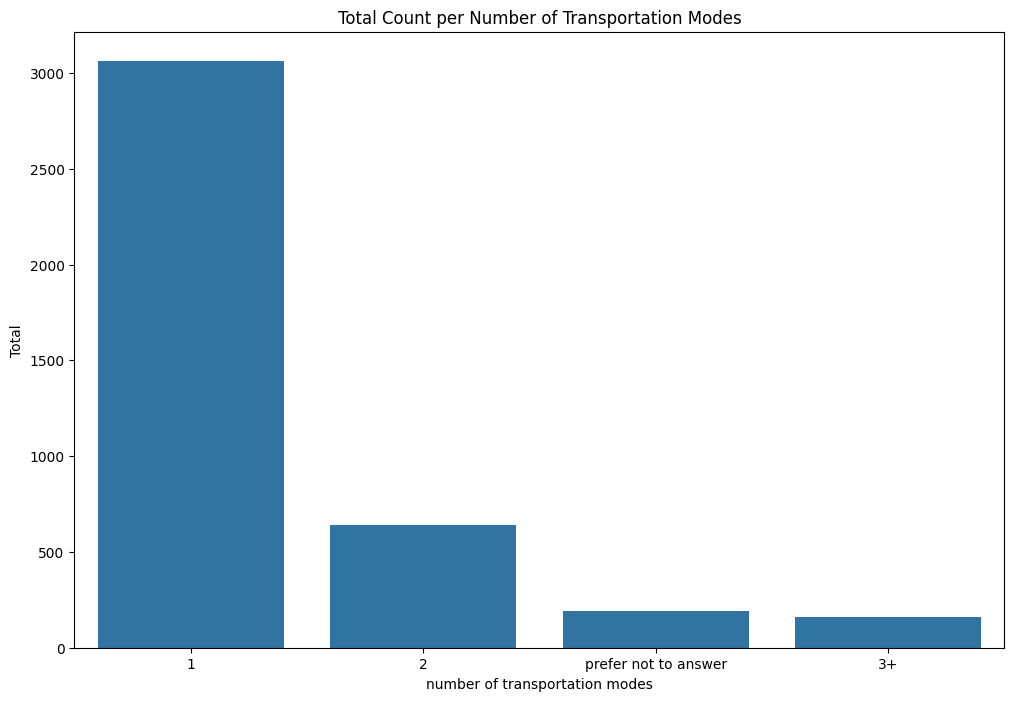

In [30]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data= overall_summary,
    x='transportation_bin',
    y='total',
    errorbar=None
)

#plt.xticks(rotation=90)
plt.xlabel('number of transportation modes')
plt.ylabel('Total')
plt.title('Total Count per Number of Transportation Modes')

# Save the figure
plt.savefig('transportation_number_of_modes.png', dpi=300, bbox_inches='tight')

# show figure
plt.show()

In [31]:
# save the above summary into a csv file:
overall_summary.to_csv('transportation_binned.csv')

Prepare a summary for the transportation mode counts (not binned)

In [32]:
summary = {}
for column in NS_transportation.columns[2:-3]:
    mode = column.split('_')
    mode = ' '.join(mode[2:])
    
    summary.update({mode: NS_transportation[column].sum(axis = 0)})


In [33]:
transportation_summary = pd.DataFrame({'mode of transportation' : summary.keys(),
             'total' : summary.values()})

In [34]:
transportation_summary = transportation_summary.sort_values(by = 'total', ascending = False)

In [35]:
transportation_summary

,mode of transportation,total
2,public,1984
0,walk,1359
3,private,948
1,cycle,520
4,prefer not to answer,193
5,food delivery option,18
6,mobility devices,8


In [36]:
# save the summary dataframe:
transportation_summary.to_csv('transportation_modes.csv', index = False)

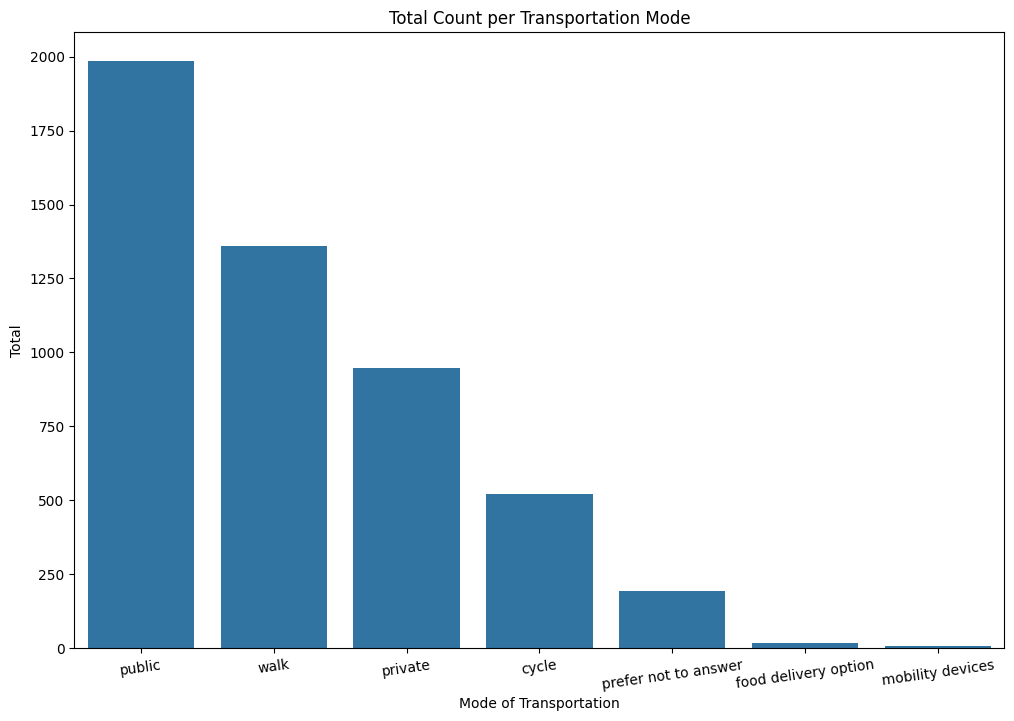

In [37]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data= transportation_summary,
    x='mode of transportation',
    y='total',
   # hue='transportation_bin',
    errorbar=None
)

plt.xticks(rotation= 8 )
plt.xlabel('Mode of Transportation')
plt.ylabel('Total')
plt.title('Total Count per Transportation Mode')

# Save the figure
plt.savefig('transportation_modes_summary.png')

# show figure
plt.show()

## Transportation Time and Modes

In [38]:
# get a summary of time answers and answers counts:
time_summary = NS_transportation[['participant_ID','time_to_get_to_most_visited_OFB']].groupby([ 'time_to_get_to_most_visited_OFB' ]).count().sort_values(by = ['participant_ID'], ascending = [False])

In [39]:
time_summary.columns = ['total']

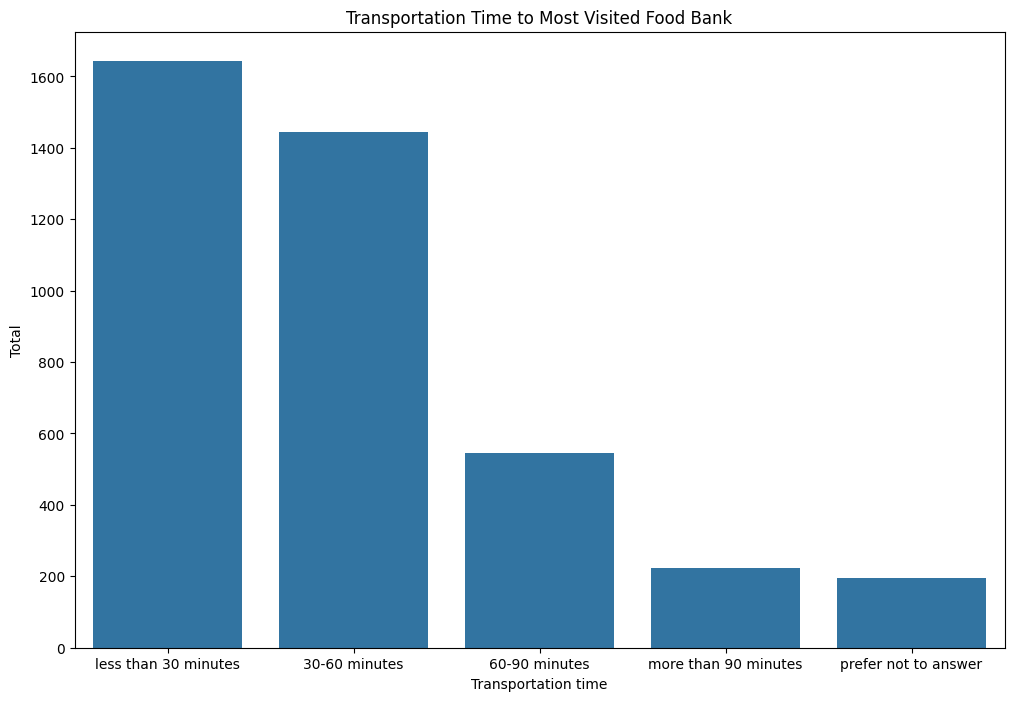

In [40]:
# plotting the data:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=time_summary,
    x='time_to_get_to_most_visited_OFB',
    y='total',
    errorbar=None
)

#plt.xticks(rotation=90)
plt.xlabel('Transportation time')
plt.ylabel('Total')
plt.title('Transportation Time to Most Visited Food Bank')

# Save the figure
plt.savefig('transportation_time.png', dpi=300, bbox_inches='tight')

# show figure
plt.show()

In [41]:
# get a summary of number of answers and answers counts:
time_detailed_summary = NS_transportation[['participant_ID','time_to_get_to_most_visited_OFB', 'transportation_consolidated', 'transportation_bin']].groupby([ 'time_to_get_to_most_visited_OFB', 'transportation_bin', 'transportation_consolidated']).count().sort_values(by = ['participant_ID'], ascending = [False])

In [42]:
time_detailed_summary

participant_ID
time_to_get_to_most_visited_OFB transportation_bin transportation_consolidated                                
30-60 minutes                   1                  public transportation                                   631
less than 30 minutes            1                  walk                                                    546
                                                   private transportation                                  440
60-90 minutes                   1                  public transportation                                   284
less than 30 minutes            1                  public transportation                                   280
...                                                                                                        ...
30-60 minutes                   1                  mobility devices                                          1
                                2                  private transportation;walk                               1
60-90 minutes                   3+                 walk;cycle;private transportation                         1
30-60 minutes                   2                  private transportation;food delivery option               1
less than 30 minutes            2                  private transportation;food delivery option               1

[84 rows x 1 columns]

In [43]:
time_detailed_summary.columns = ['total']

In [44]:
time_detailed_summary = time_detailed_summary.reset_index()

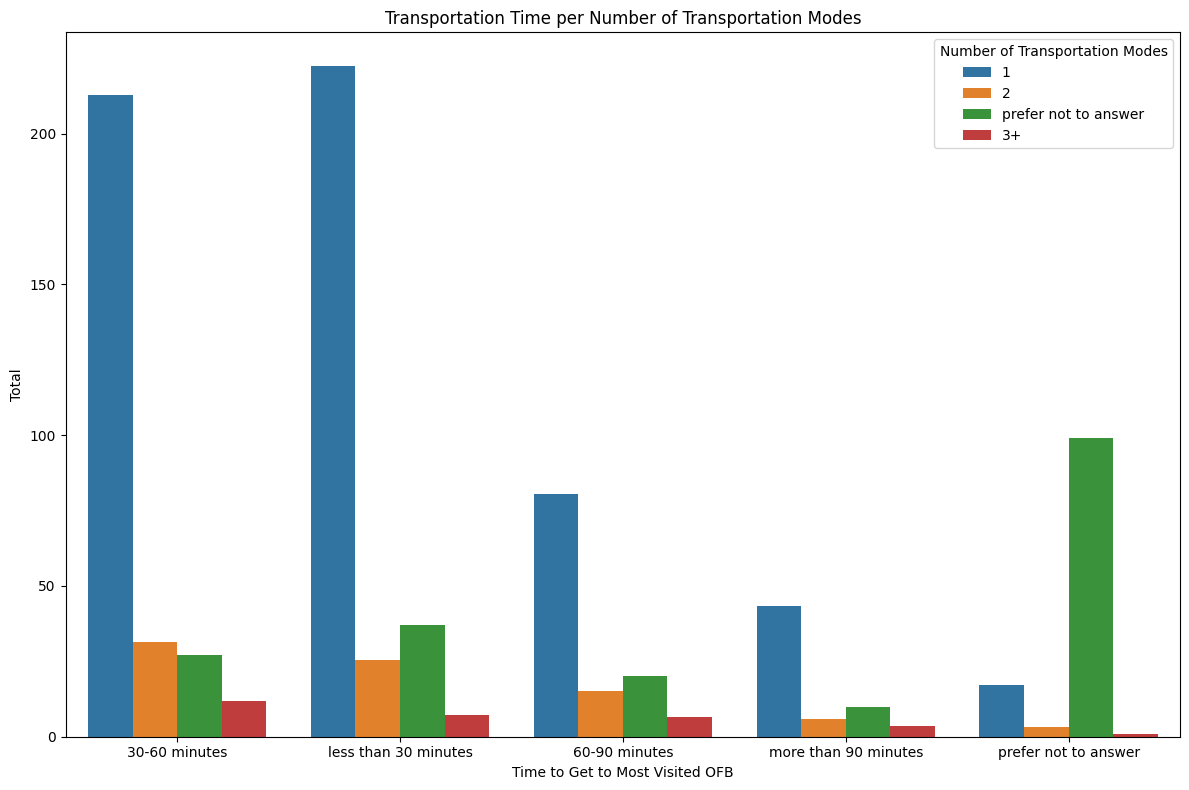

In [45]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=time_detailed_summary,
    x='time_to_get_to_most_visited_OFB',
    y='total',
    hue='transportation_bin',
    errorbar=None
)

#plt.xticks(rotation=90)
plt.xlabel('Time to Get to Most Visited OFB')
plt.ylabel('Total')
plt.title('Transportation Time per Number of Transportation Modes')

# Rename legend
plt.legend(title='Number of Transportation Modes')

# Adjust layout to make room for the legend
plt.tight_layout()

# Save the figure
plt.savefig('transportation_time_modes_summary.png', dpi=300, bbox_inches='tight')

# show figure
plt.show()

In [46]:
# save the above to a csv.
time_detailed_summary.to_csv('NS_transportation_time_modes.csv', index = False)

In [47]:
# get a summary of number of answers and answers counts:
detailed_summary = NS_transportation[['participant_ID','transportation_bin','transportation_consolidated']].groupby(['transportation_bin', 'transportation_consolidated']).count().sort_values(by = ['transportation_bin','participant_ID'], ascending = [True,False])

In [48]:
detailed_summary.columns = ['total']

In [49]:
# save the detailed summary into a csv file.
detailed_summary.to_csv('transportation_detailed_summary.csv')

In [50]:
detailed_summary

total
transportation_bin   transportation_consolidated                              
1                    public transportation                                1330
                     walk                                                  790
                     private transportation                                697
                     cycle                                                 225
                     food delivery option                                   14
                     mobility devices                                        6
2                    walk;public transportation                            288
                     public transportation;private transportation          118
                     cycle;public transportation                            93
                     walk;cycle                                             86
                     walk;private transportation                            41
                     cycle;private transportation                            7
                     private transportation;food delivery option             2
                     public transportation;walk                              2
                     private transportation;public transportation            1
                     private transportation;walk                             1
                     public transportation;food delivery option              1
3+                   walk;cycle;public transportation                       76
                     walk;public transportation;private transportation      47
                     walk;cycle;public transportation;private transp...     18
                     cycle;public transportation;private transportation      8
                     walk;cycle;private transportation                       7
                     walk;public transportation;mobility devices             2
                     walk;private transportation;food delivery option        1
prefer not to answer prefer not to answer                                  193

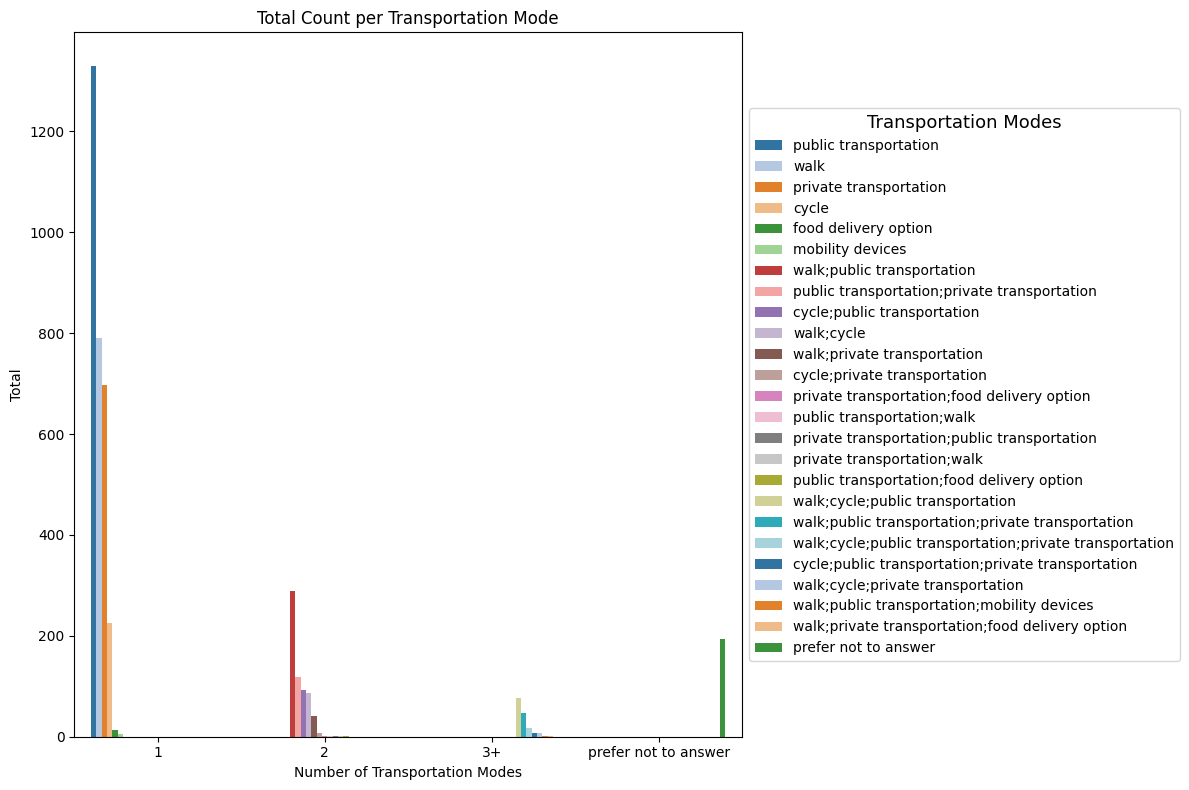

In [51]:
# graph the data
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data= detailed_summary,
    x='transportation_bin',
    y='total',
    hue='transportation_consolidated',
    palette=sns.color_palette("tab20", n_colors=25),
    errorbar=None
)

#plt.xticks(rotation=90)
plt.xlabel('Number of Transportation Modes')
plt.ylabel('Total')
plt.title('Total Count per Transportation Mode')

# Adjust the legend
plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),  # Position the legend
    ncol=1,  # Number of columns in the legend
    title='Transportation Modes',
    title_fontsize='13',
    fontsize='10'
)

# Adjust layout to make room for the legend
plt.tight_layout()

# Save the figure
plt.savefig('transportation_summary_detailed.png', dpi=300, bbox_inches='tight')

# show the figure
plt.show()